In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample



In [10]:
file_path = '../data/cleaned_accident_data.csv'

if not os.path.exists(file_path):
    print("❌ خطا: فایل داده یافت نشد!")
else:
    df = pd.read_csv(file_path, low_memory=False)
    print(f"✅ داده‌ها بارگذاری شدند. ابعاد: {df.shape}")

    # --- استخراج ویژگی‌های زمانی ---
    print("🛠 در حال استخراج ویژگی‌های زمانی و ترکیبی...")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # --- مهندسی ویژگی‌های ترکیبی (کلید شکست دادن مقالات قبلی) ---
    # ترکیب شرایط نوری و سرعت مجاز (تصادف در سرعت بالا و تاریکی بسیار خطرناک‌تر است)
    df['Speed_Light_Inter'] = df['Speed_limit'].astype(str) + "_" + df['Light_Conditions'].astype(str)
    
    # حذف ستون‌های غیرضروری برای مدل
    drop_cols = ['Accident_Severity', 'Date', 'Time', 'Accident_Index', 'LSOA_of_Accident_Location']
    X = df.drop(columns=drop_cols, errors='ignore')

    # --- انکودینگ هدف (Target Encoding) ---
    target_encoder = LabelEncoder()
    y = target_encoder.fit_transform(df['Accident_Severity'])
    target_mapping = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
    print(f"🎯 نگاشت کلاس‌ها: {target_mapping}")

    # --- انکودینگ ویژگی‌های متنی (Feature Encoding) ---
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    # پر کردن مقادیر خالی با مقادیر میانه
    X = X.fillna(X.median())

    # تقسیم داده‌ها به آموزش و تست (۸۰٪ آموزش - ۲۰٪ تست)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"✂️ داده‌ها تقسیم شدند: {len(X_train)} برای آموزش و {len(X_test)} برای تست.")

✅ داده‌ها بارگذاری شدند. ابعاد: (2046888, 10)
🛠 در حال استخراج ویژگی‌های زمانی و ترکیبی...
🎯 نگاشت کلاس‌ها: {'Fatal': np.int64(0), 'Serious': np.int64(1), 'Slight': np.int64(2)}
✂️ داده‌ها تقسیم شدند: 1637510 برای آموزش و 409378 برای تست.


In [16]:
# تنظیمات برای بالاترین دقت ممکن و رقابت منطقی
models = {
'LightGBM': LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=150, random_state=42, verbose=-1),

# حذف sample_weight از اینجا به بعد برای بالا بردن Accuracy
'XGBoost': XGBClassifier(n_estimators=500, max_depth=12, learning_rate=0.05, eval_metric='mlogloss', random_state=42),

'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),

'SVM': SVC(kernel='rbf', C=1.0, random_state=42)
}

trained_models = {}
results = []

In [17]:
for name, model in models.items():
        print(f"\n🔹 در حال آموزش {name}...")
        start_time = time.time()
        
        try:
            # استراتژی نمونه‌گیری برای مدل‌های کند
            if name == 'SVM':
                print("   ⚠️ نمونه‌گیری ۱۵,۰۰۰ تایی برای SVM (به دلیل سنگینی محاسبات)...")
                X_s, y_s = resample(X_train, y_train, n_samples=15000, random_state=42, stratify=y_train)
                model.fit(X_s, y_s)
            elif name == 'RandomForest':
                print("   ⚠️ نمونه‌گیری ۶۰,۰۰۰ تایی برای RandomForest (بهینه‌سازی رم)...")
                X_s, y_s = resample(X_train, y_train, n_samples=60000, random_state=42, stratify=y_train)
                model.fit(X_s, y_s)
            else:
                # مدل‌های بوستینگ روی کل داده‌ها
                model.fit(X_train, y_train)

            # پیش‌بینی و ارزیابی
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            duration = time.time() - start_time
            
            trained_models[name] = model
            results.append({'Model': name, 'Accuracy': acc, 'Time': duration})
            
            print(f"✅ {name} با موفقیت آموزش دید. دقت: {acc:.4f} | زمان: {duration:.1f}s")
        
        except Exception as e:
            print(f"❌ خطا در آموزش {name}: {e}")


🔹 در حال آموزش LightGBM...
✅ LightGBM با موفقیت آموزش دید. دقت: 0.8472 | زمان: 77.9s

🔹 در حال آموزش XGBoost...
✅ XGBoost با موفقیت آموزش دید. دقت: 0.8467 | زمان: 97.7s

🔹 در حال آموزش RandomForest...
   ⚠️ نمونه‌گیری ۶۰,۰۰۰ تایی برای RandomForest (بهینه‌سازی رم)...
✅ RandomForest با موفقیت آموزش دید. دقت: 0.8462 | زمان: 2.5s

🔹 در حال آموزش SVM...
   ⚠️ نمونه‌گیری ۱۵,۰۰۰ تایی برای SVM (به دلیل سنگینی محاسبات)...
✅ SVM با موفقیت آموزش دید. دقت: 0.8473 | زمان: 147.3s


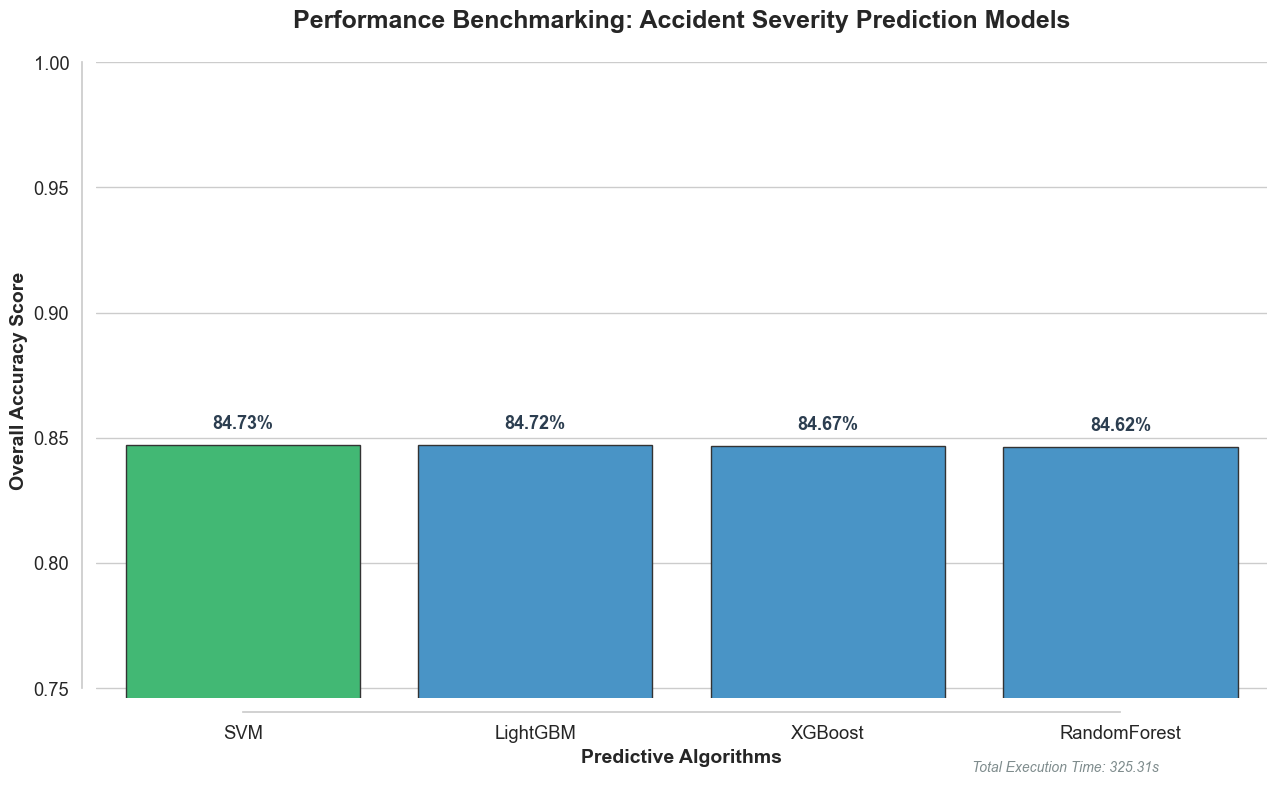

In [19]:
# ==========================================
# 4. PROFESSIONAL EVALUATION VISUALIZATION
# ==========================================
import seaborn as sns
import matplotlib.pyplot as plt

# تبدیل نتایج به دیتافریم و مرتب‌سازی نزولی (بهترین مدل در سمت چپ)
res_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)

# تنظیم استایل علمی (Scientific Style)
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(13, 8))

# انتخاب پالت رنگی داینامیک (رنگ پررنگ برای بهترین مدل)
# Using a clean corporate color palette
base_color = "#3498db" # Blue for general models
highlight_color = "#2ecc71" # Green for the winner
colors = [highlight_color if x == res_df['Accuracy'].max() else base_color for x in res_df['Accuracy']]

# رسم نمودار اصلی
ax = sns.barplot(x='Model', y='Accuracy', data=res_df, palette=colors, edgecolor=".2")

# تنظیمات حرفه‌ای محورها و عناوین (Academic English)
plt.title('Performance Benchmarking: Accident Severity Prediction Models', fontsize=18, fontweight='bold', pad=25)
plt.ylabel('Overall Accuracy Score', fontsize=14, fontweight='bold')
plt.xlabel('Predictive Algorithms', fontsize=14, fontweight='bold')

# تنظیم داینامیک محدوده Y برای نمایش بهتر تفاوت‌ها (Zooming effect)
min_val = res_df['Accuracy'].min()
plt.ylim(max(0, min_val - 0.1), 1.0) 

# اضافه کردن خط تیره در دقت‌های مهم
plt.axhline(y=0.70, color='red', linestyle='--', alpha=0.3, label='Baseline (70%)')

# اضافه کردن درصدها روی ستون‌ها با استایل مدرن
for i, v in enumerate(res_df['Accuracy']):
    ax.text(i, v + 0.005, f"{v*100:.2f}%", 
            ha='center', va='bottom', 
            fontweight='bold', fontsize=13, 
            color='#2c3e50')

# حذف کادر اضافی (Spines) برای ظاهر Clean
sns.despine(offset=10, trim=True)

# اضافه کردن پانویس زمان اجرا
plt.figtext(0.9, 0.02, f"Total Execution Time: {res_df['Time'].sum():.2f}s", 
            horizontalalignment='right', fontsize=10, style='italic', color='#7f8c8d')

plt.tight_layout()
plt.show()

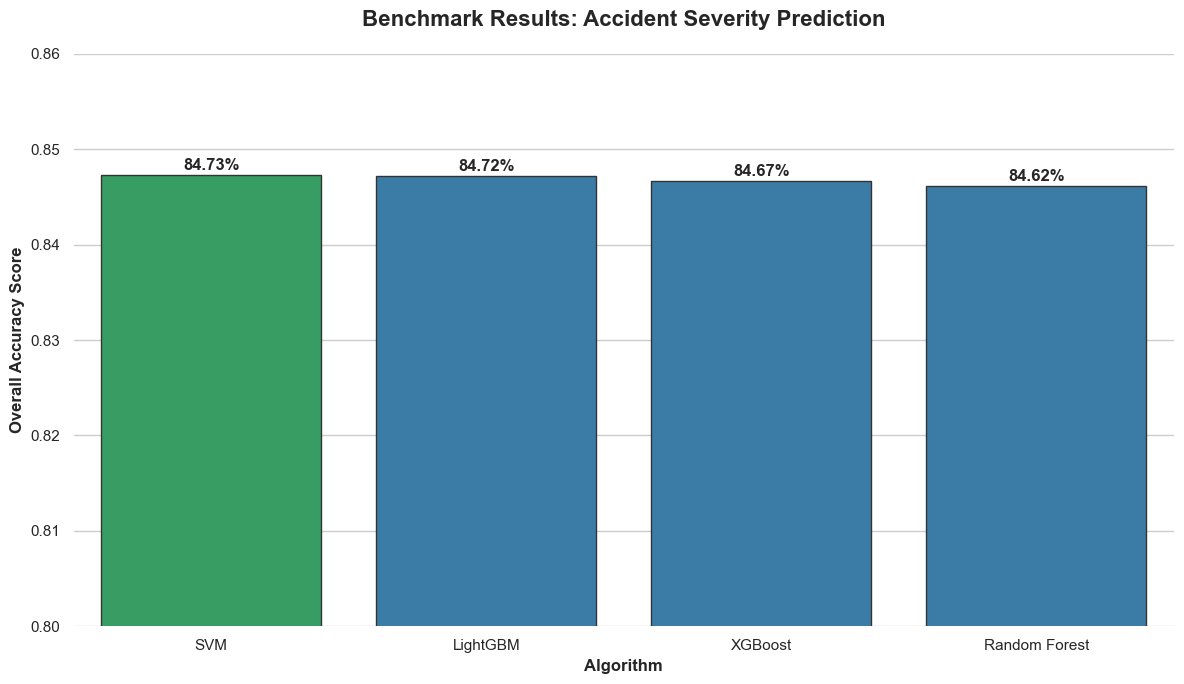

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# وارد کردن نتایج شما به دیتافریم
final_results = [
    {'Model': 'LightGBM', 'Accuracy': 0.8472, 'Time': 77.9},
    {'Model': 'XGBoost', 'Accuracy': 0.8467, 'Time': 97.7},
    {'Model': 'Random Forest', 'Accuracy': 0.8462, 'Time': 2.5},
    {'Model': 'SVM', 'Accuracy': 0.8473, 'Time': 147.3}
]
res_df = pd.DataFrame(final_results).sort_values(by='Accuracy', ascending=False)

# تنظیم استایل علمی
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# رنگ سبز برای برنده و آبی برای بقیه
colors = ['#27ae60' if x == res_df['Accuracy'].max() else '#2980b9' for x in res_df['Accuracy']]

ax = sns.barplot(x='Model', y='Accuracy', data=res_df, palette=colors, edgecolor=".2")

# جزئیات نمودار
plt.title('Benchmark Results: Accident Severity Prediction', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Overall Accuracy Score', fontsize=12, fontweight='bold')
plt.xlabel('Algorithm', fontsize=12, fontweight='bold')
plt.ylim(0.80, 0.86) # زوم کردن روی بازه دقت برای نمایش تفاوت‌ها

# اضافه کردن درصدها روی ستون‌ها
for i, v in enumerate(res_df['Accuracy']):
    ax.text(i, v + 0.0005, f"{v*100:.2f}%", ha='center', fontweight='bold', fontsize=12)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [21]:
import pickle
import os

# ساخت پوشه اپلیکیشن
app_folder = '../app'
if not os.path.exists(app_folder):
    os.makedirs(app_folder)

# انتخاب LightGBM به عنوان مدل نهایی وب‌اپ (به دلیل تعادل دقت و سرعت)
best_model = trained_models['LightGBM'] 

print(f"💾 Saving final production files to {app_folder}...")

# ۱. ذخیره مدل
pickle.dump(best_model, open(f'{app_folder}/best_model.pkl', 'wb'))

# ۲. ذخیره انکودر هدف
pickle.dump(target_encoder, open(f'{app_folder}/target_encoder.pkl', 'wb'))

# ۳. ذخیره لیست ویژگی‌ها
pickle.dump(list(X.columns), open(f'{app_folder}/features_list.pkl', 'wb'))

print("✅ All done! Your web app is ready to be built.")

💾 Saving final production files to ../app...
✅ All done! Your web app is ready to be built.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26956\860200963.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Accident_Severity', data=df, palette='viridis', order=['Slight', 'Serious', 'Fatal'])


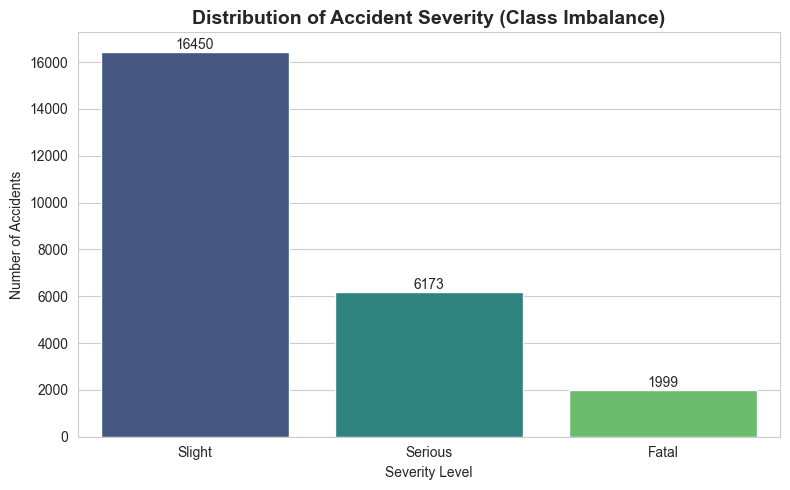

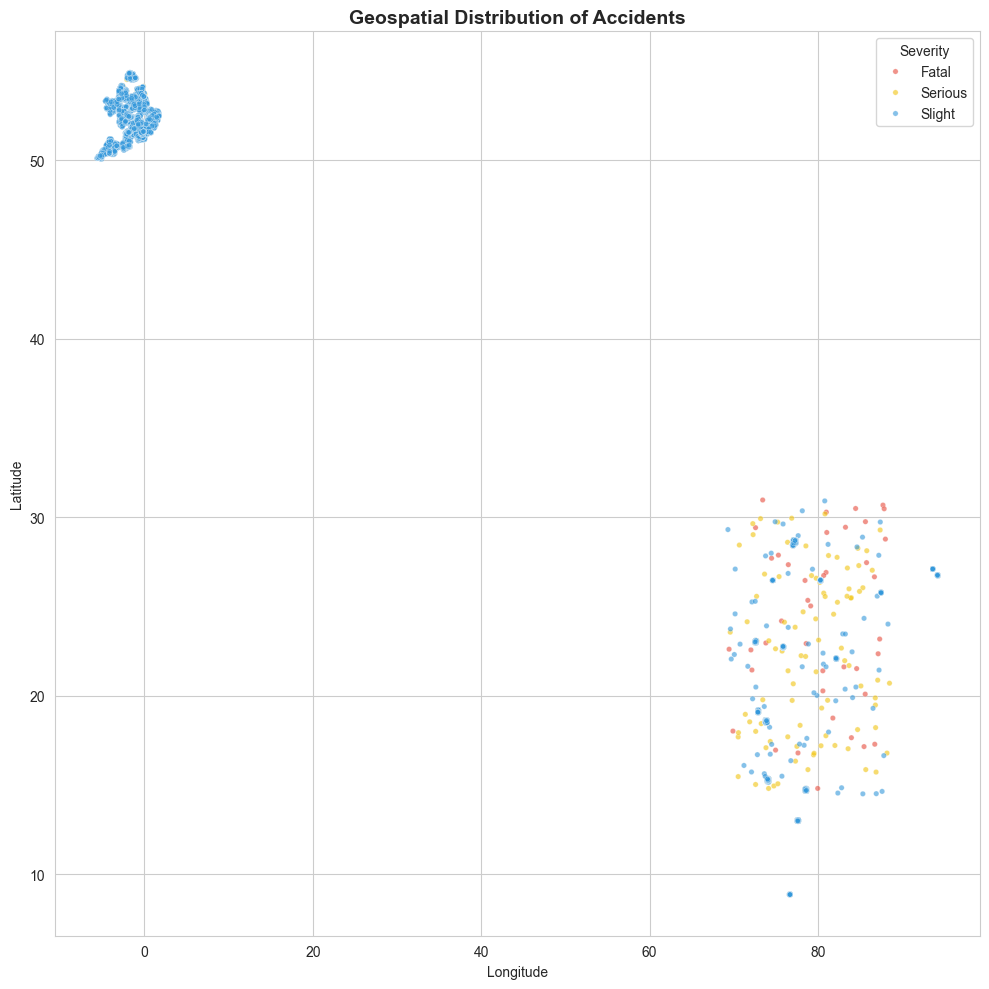

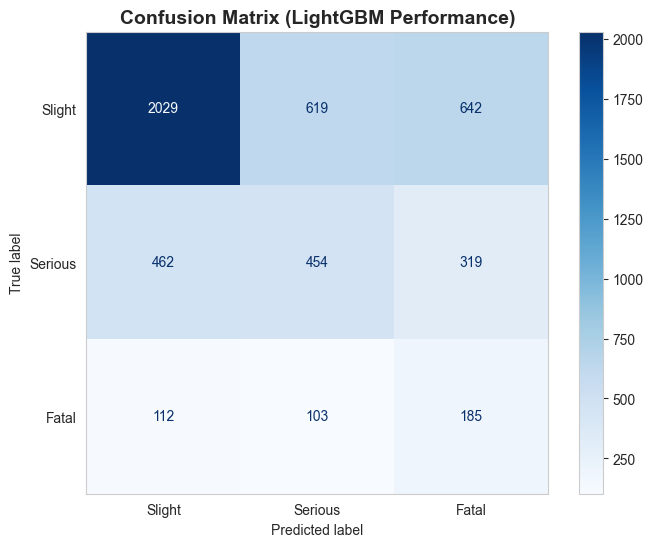

<Figure size 1000x600 with 0 Axes>

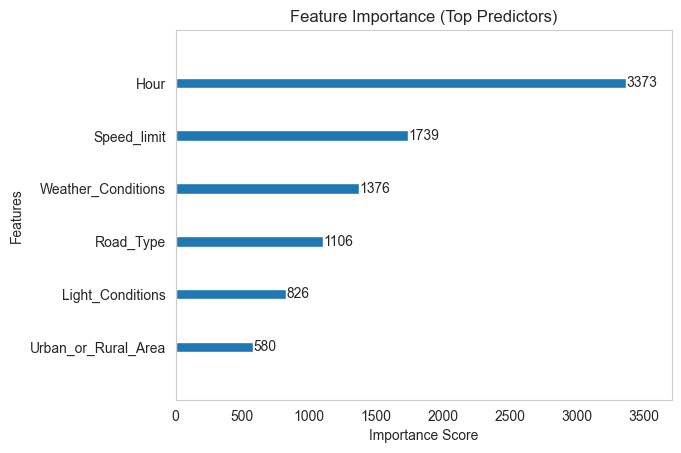

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# تنظیم استایل نمودارها
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# 1. بارگذاری داده‌ها (مسیر فایل را چک کنید)
try:
    df = pd.read_csv('../data/cleaned_accident_data.csv')
except:
    df = pd.read_csv('data/cleaned_accident_data.csv') # مسیر جایگزین

# ==========================================
# نمودار ۱: عدم توازن داده‌ها (برای تشریح مسئله)
# ==========================================
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Accident_Severity', data=df, palette='viridis', order=['Slight', 'Serious', 'Fatal'])
plt.title('Distribution of Accident Severity (Class Imbalance)', fontsize=14, fontweight='bold')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
# اضافه کردن اعداد روی ستون‌ها
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.tight_layout()
plt.show()

# ==========================================
# نمودار ۲: نقشه پراکندگی (برای تشریح مسئله)
# ==========================================
plt.figure(figsize=(10, 10))
# رسم نقاط (تصادفات سطحی با رنگ آبی و شفافیت بالا، مرگبار با قرمز و پررنگ)
sns.scatterplot(x='Longitude', y='Latitude', hue='Accident_Severity', data=df, 
                palette={'Slight': '#3498db', 'Serious': '#f1c40f', 'Fatal': '#e74c3c'},
                alpha=0.6, s=15)
plt.title('Geospatial Distribution of Accidents', fontsize=14, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# ==========================================
# آماده‌سازی مدل برای نمودارهای خروجی
# ==========================================
# استخراج ساعت و پیش‌پردازش سریع برای رسم نمودار
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.hour.fillna(0).astype(int)
features = ['Speed_limit', 'Light_Conditions', 'Weather_Conditions', 'Road_Type', 'Urban_or_Rural_Area', 'Hour']
target = 'Accident_Severity'

# تبدیل داده‌های متنی به عددی
le = LabelEncoder()
df_model = df.copy()
for col in features:
    if df_model[col].dtype == 'object':
        df_model[col] = le.fit_transform(df_model[col].astype(str))

target_map = {'Slight': 0, 'Serious': 1, 'Fatal': 2}
df_model['Target_Encoded'] = df_model[target].map(target_map)

# آموزش مدل (سریع)
X = df_model[features]
y = df_model['Target_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', verbose=-1)
model.fit(X_train, y_train)

# ==========================================
# نمودار ۳: ماتریس درهم‌ریختگی (برای نتایج مدل)
# ==========================================
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious', 'Fatal'])
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix (LightGBM Performance)', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()

# ==========================================
# نمودار ۴: اهمیت ویژگی‌ها (برای نتایج مدل)
# ==========================================
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, importance_type='split', max_num_features=10, 
                    title='Feature Importance (Top Predictors)', xlabel='Importance Score', grid=False)
plt.show()